In [73]:
import sys, os

path = os.getcwd()
pwd_path = os.path.abspath(os.path.join(path, os.pardir))
sys.path.append(pwd_path)

In [74]:
import json
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from model.manicast import ManiCast
import torch
from IPython.display import display, clear_output
from matplotlib.animation import FuncAnimation
%matplotlib inline

relevant_joints=['BackTop', 'LShoulderBack', 'RShoulderBack',
                'LElbowOut', 'RElbowOut', 'LWristOut', 'RWristOut', 'WaistLBack', 'WaistRBack']

#Change these values to desired model names, and data episode paths:
model_checkpoint = 'base'

dataset_folder = f"{pwd_path}/data/comad_data/"
mapping_file = f"{pwd_path}/mapping.json"

episode_file = f"{dataset_folder}handover/train/handover_4.json"

model = ManiCast(3,10, 25, .1, 7, 4,[3,3],0.0).to('cpu')

model_name='amass_3d_'+str(25)+'frames_ckpt'

model.load_state_dict(torch.load(f'{pwd_path}/model_checkpoints/{model_checkpoint}'))
model.eval()

with open(mapping_file, 'r') as f:
    mapping = json.load(f)

with open(episode_file, 'r') as f:
    data = json.load(f)

In [75]:
def get_relevant_joints(all_joints, relevant_joints = relevant_joints):                       
    relevant_joint_pos = []
    for joint in relevant_joints:
        pos = all_joints[mapping[joint]]
        relevant_joint_pos.append(pos)
    return relevant_joint_pos

In [76]:
def get_history(all_joints, current_idx, history_length=10, skip_rate = 5):
    history_joints = []
    for i in range(current_idx-(history_length-1)*skip_rate, current_idx+1, skip_rate):
        idx = max(0, i)
        history_joints.append(get_relevant_joints(all_joints[idx]))
    return history_joints

In [77]:
def get_future(all_joints, current_idx, future_length=25, skip_rate = 5):
    future_joints = []
    for i in range(current_idx+skip_rate, current_idx + future_length*skip_rate + 1, skip_rate):
        idx = min(i, all_joints.shape[0]-1)
        future_joints.append(get_relevant_joints(all_joints[idx]))
    return future_joints

In [78]:
def get_forecast(history_joints):
    history_joints = torch.Tensor(np.array(history_joints)).unsqueeze(0)
    current_left_hip = history_joints[:,-2:-1,-2:-1,:]
    current_hips = history_joints[:,-2:-1,-2:,:]
    history_joints = history_joints - current_left_hip
    sequences_train=history_joints[:,:,:-2].permute(0,3,1,2)
    with torch.no_grad():
        sequences_predict=model(sequences_train).permute(0,1,3,2)
    current_hips_repeat = current_hips.repeat(1, sequences_predict.shape[1], 1, 1)
    forecast_joints = torch.cat([sequences_predict+current_left_hip, current_hips_repeat], dim=2)
    # import pdb; pdb.set_trace()
    return forecast_joints[0].cpu().numpy()

In [79]:
def get_point_array(current_joints, future_joints, forecast_joints, figures, ax, update, prev, threshold):
    edges = [
            (0, 1), (0, 2),
            (1, 3), (3, 5),
            (2, 4), (4, 6)
        ]
    # extra edges to connect the pose back to the hips
    extra_edges = [(1, 7), (7, 8), (8, 2)]
    if current_joints is not None:
        for idx, edge in enumerate(edges + extra_edges):
            pos1, pos2 = current_joints[edge[0]], current_joints[edge[1]]
            x1,y1,z1= pos1.tolist()
            x2,y2,z2 = pos2.tolist()
            x = np.array([-x1, -x2])
            y = np.array([y1, y2])
            z = np.array([z1, z2])
            if not update:
                figures[0][0].append(ax.plot(x, z, y, zdir='z', c = 'black', alpha = 1))
                figures[0][1].append(ax.scatter(x, z, y, s = 10, c = 'black', alpha = 1))
            else:
                difference_1 = np.array([(prev[0][idx][0] - x)[0], (prev[0][idx][1] - y)[0], (prev[0][idx][1] - z)[0]])
                difference_2 = np.array([(prev[0][idx][0] - x)[1], (prev[0][idx][1] - y)[1], (prev[0][idx][1] - z)[1]])
                if np.linalg.norm(difference_1) > threshold or np.linalg.norm(difference_2) > threshold:
                    x, y, z = prev[0][idx]
                figures[0][0][idx][0].set_xdata(x)
                figures[0][0][idx][0].set_ydata(z)
                figures[0][0][idx][0].set_3d_properties(y)

                figures[0][1][idx]._offsets3d = (x, z, y)
            prev[0].append((x, y, z))
    if forecast_joints is not None or future_joints is not None:
        for i, time in enumerate([24]):
            for idx, edge in enumerate(edges + extra_edges):
                if forecast_joints is not None:
                    joints = forecast_joints[time]
                    pos1, pos2 = joints[edge[0]], joints[edge[1]]
                    x1,y1,z1= pos1.tolist()
                    x2,y2,z2 = pos2.tolist()
                    x = np.array([-x1, -x2])
                    y = np.array([y1, y2])
                    z = np.array([z1, z2])
                    if not update:
                        figures[1][0].append(ax.plot(x, z, y, zdir='z', c = 'blue', alpha = 0.9-0.1*((time+1)/25)))
                        figures[1][1].append(ax.scatter(x, z, y, s = 10, c = 'blue', alpha = 0.9-0.1*((time+1)/25)))
                    else:
                        difference_1 = np.array([(prev[1][idx][0] - x)[0], (prev[1][idx][1] - y)[0], (prev[1][idx][1] - z)[0]])
                        difference_2 = np.array([(prev[1][idx][0] - x)[1], (prev[1][idx][1] - y)[1], (prev[1][idx][1] - z)[1]])
                        if np.linalg.norm(difference_1) > threshold or np.linalg.norm(difference_2) > threshold:
                            x, y, z = prev[1][idx]
                    
                        figures[1][0][idx][0].set_xdata(x)
                        figures[1][0][idx][0].set_ydata(z)
                        figures[1][0][idx][0].set_3d_properties(y)

                        figures[1][1][idx]._offsets3d = (x, z, y)
                    prev[1].append((x, y, z))
                if future_joints is not None:
                    joints = future_joints[time]
                    pos1, pos2 = joints[edge[0]], joints[edge[1]]
                    x1,y1,z1= pos1.tolist()
                    x2,y2,z2 = pos2.tolist()
                    x = np.array([-x1, -x2])
                    y = np.array([y1, y2])
                    z = np.array([z1, z2])
                    if not update:
                        figures[2][0].append(ax.plot(x, z, y, zdir='z', c = 'green', alpha = 0.9-0.1*((time+1)/25)))
                        figures[2][1].append(ax.scatter(x, z, y, s = 10, c = 'green', alpha = 0.9-0.1*((time+1)/25)))
                    else:
                        difference_1 = np.array([(prev[2][idx][0] - x)[0], (prev[2][idx][1] - y)[0], (prev[2][idx][1] - z)[0]])
                        difference_2 = np.array([(prev[2][idx][0] - x)[1], (prev[2][idx][1] - y)[1], (prev[2][idx][1] - z)[1]])
                        if np.linalg.norm(difference_1) > threshold or np.linalg.norm(difference_2) > threshold:
                            x, y, z = prev[2][idx]
                        figures[2][0][idx][0].set_xdata(x)
                        figures[2][0][idx][0].set_ydata(z)
                        figures[2][0][idx][0].set_3d_properties(y)

                        figures[2][1][idx]._offsets3d = (x, z, y)
                    prev[2].append((x, y, z))

0.0


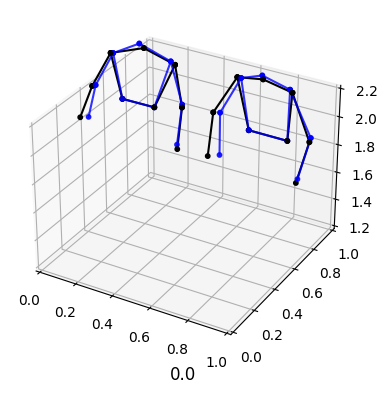

0.0


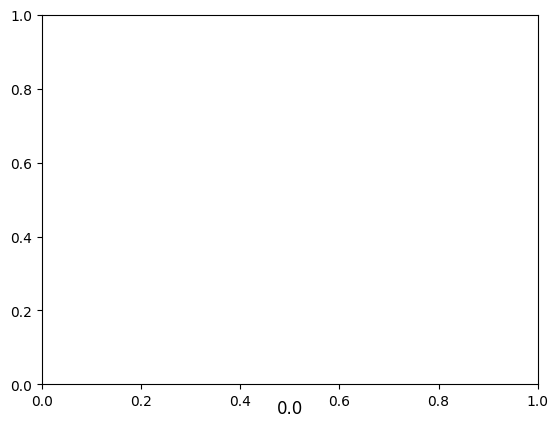

0.1


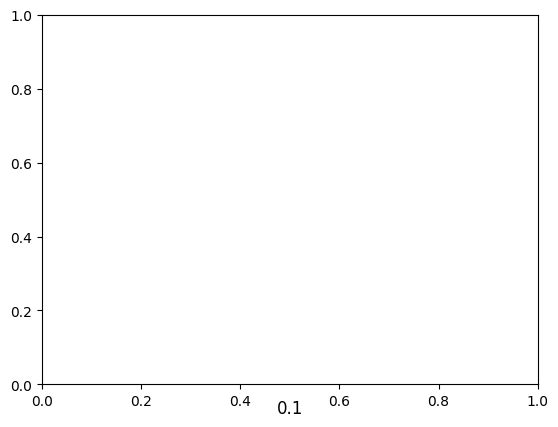

0.1


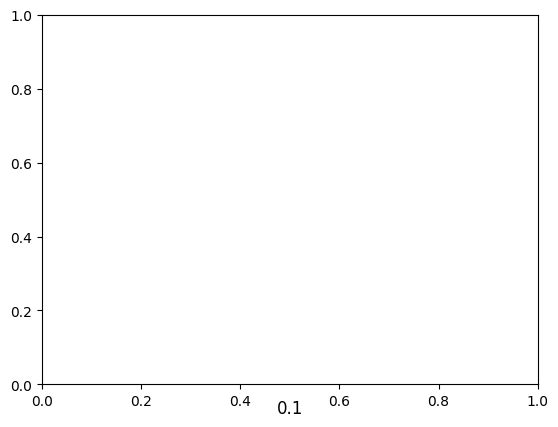

0.2


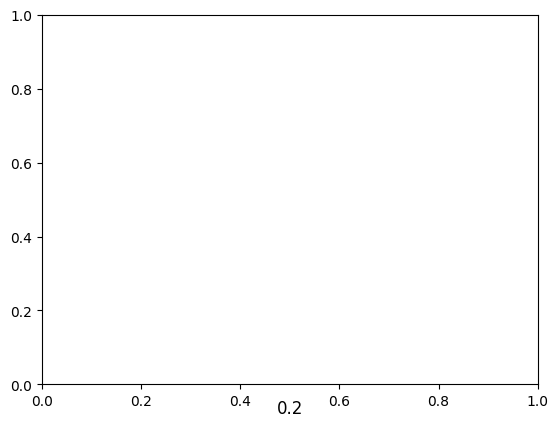

0.2


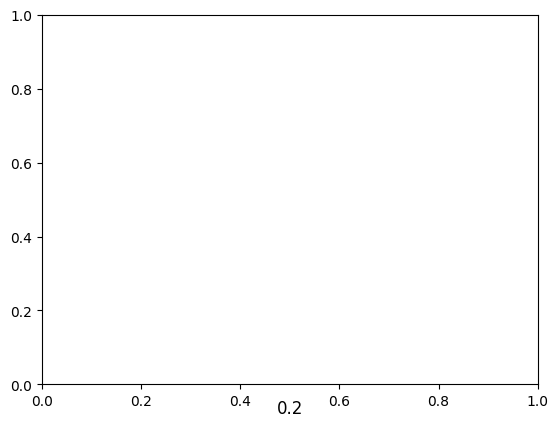

0.2


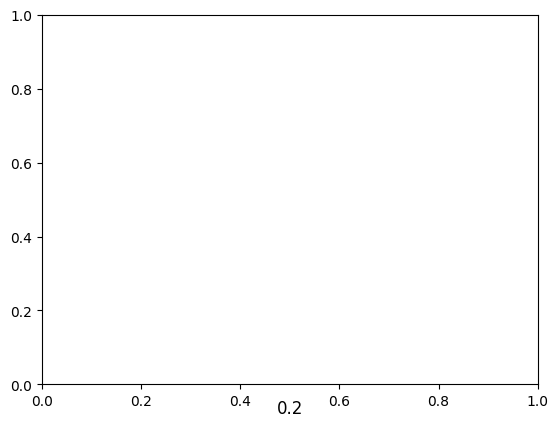

0.3


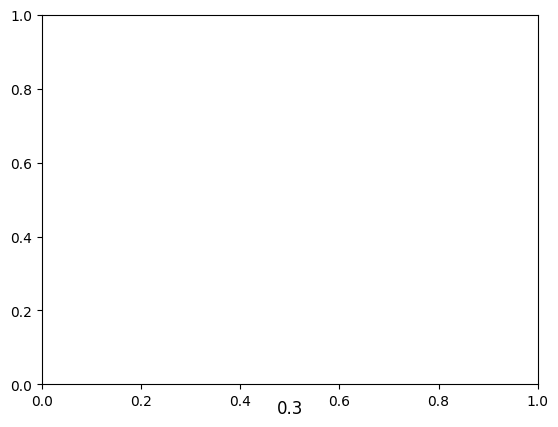

0.3


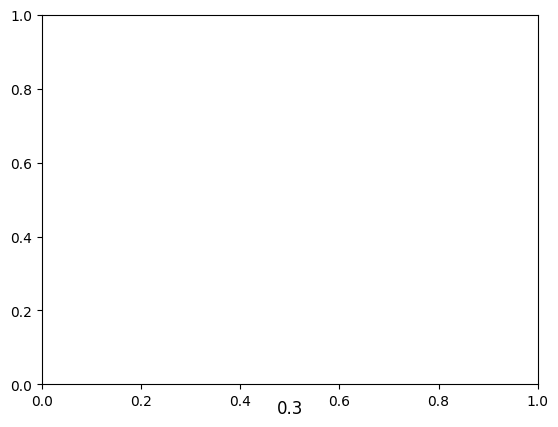

0.4


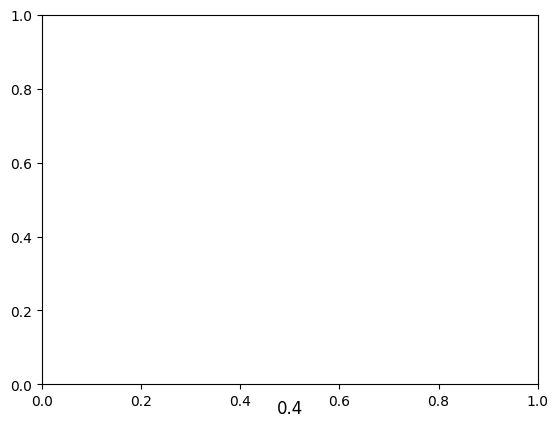

0.4


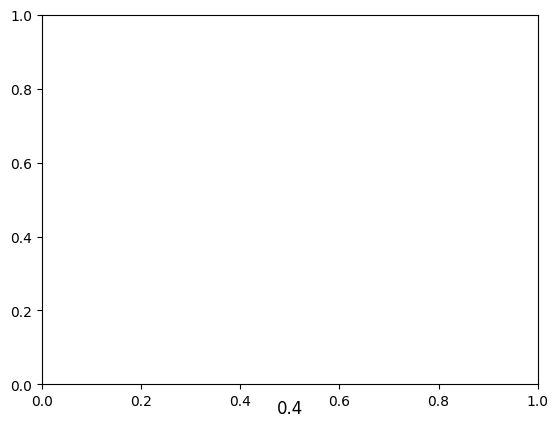

0.5


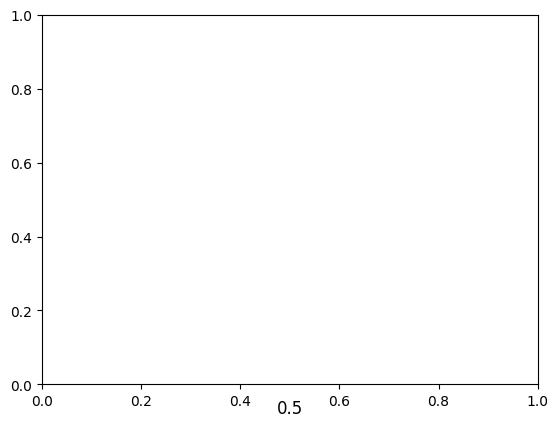

0.5


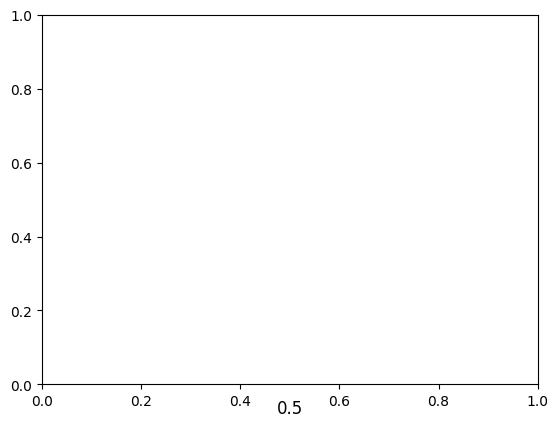

0.5


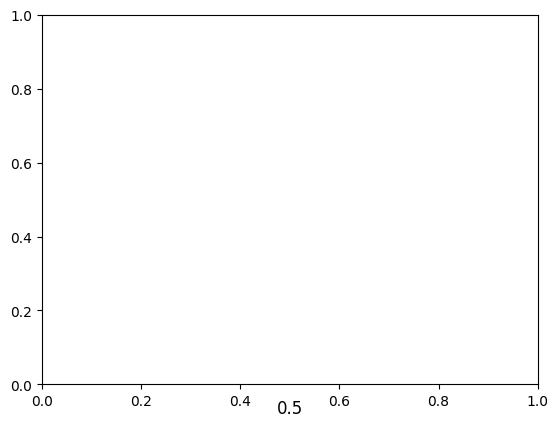

0.6


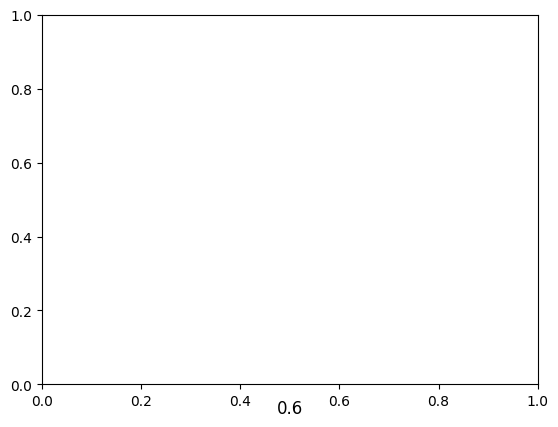

0.6


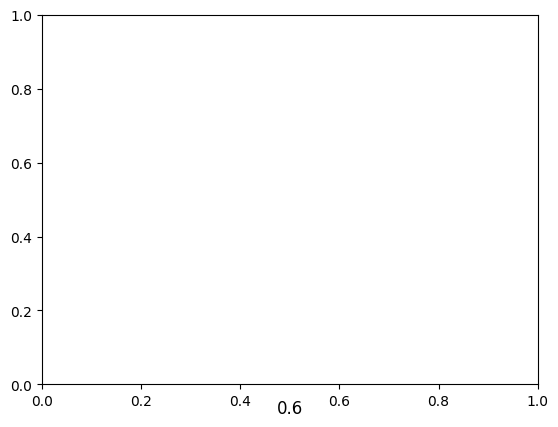

0.7


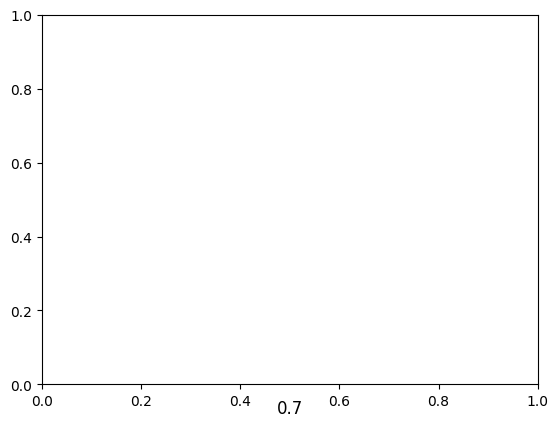

0.7


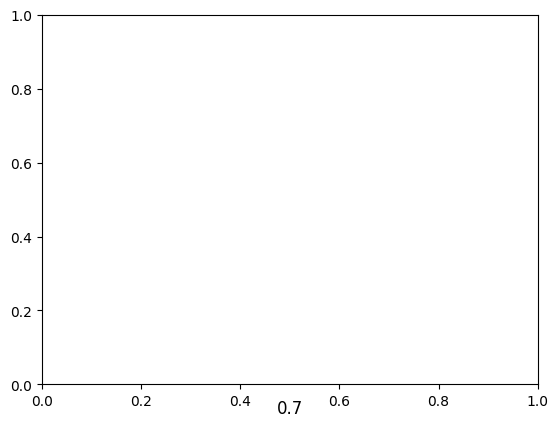

0.8


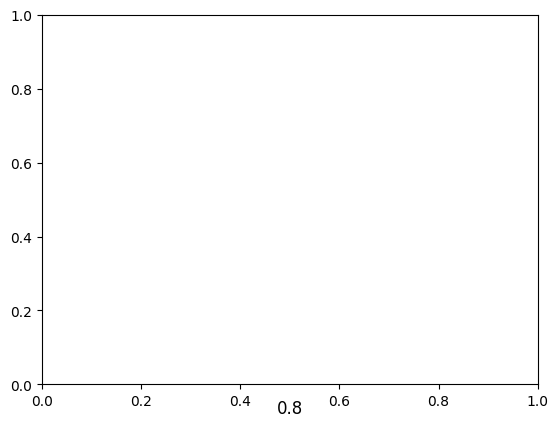

0.8


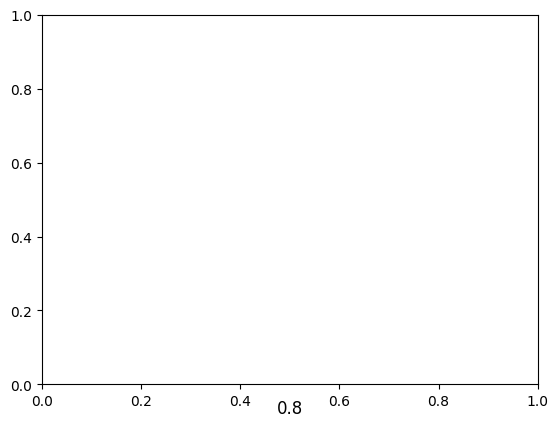

0.8


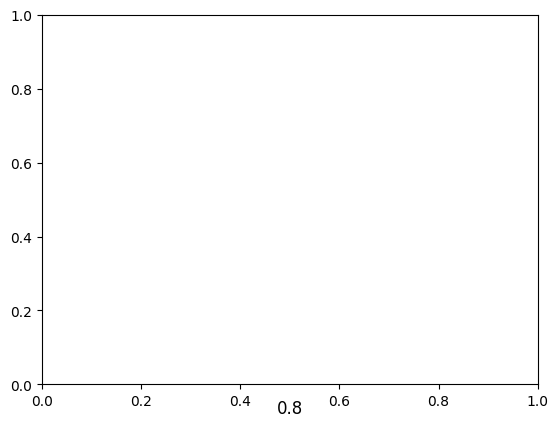

0.9


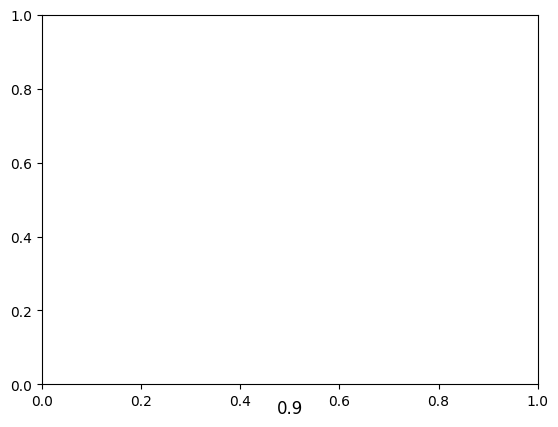

0.9


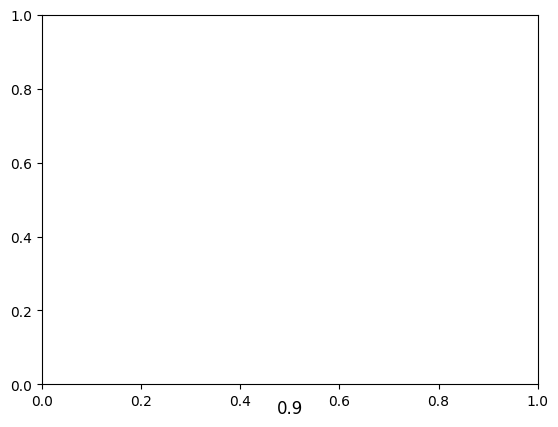

1.0


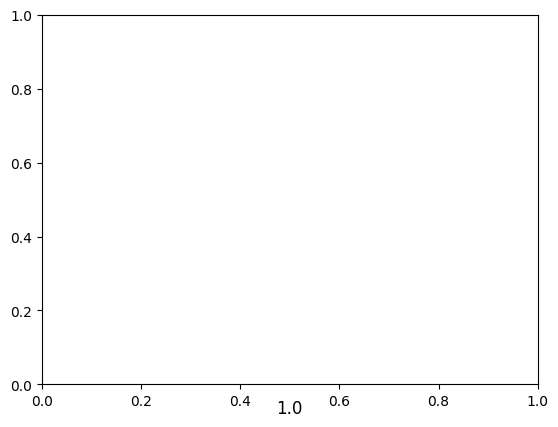

1.0


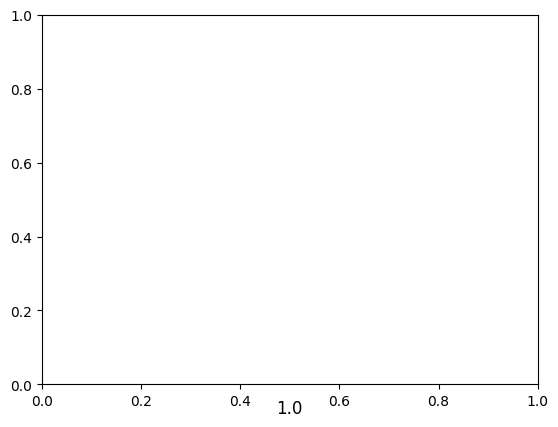

1.0


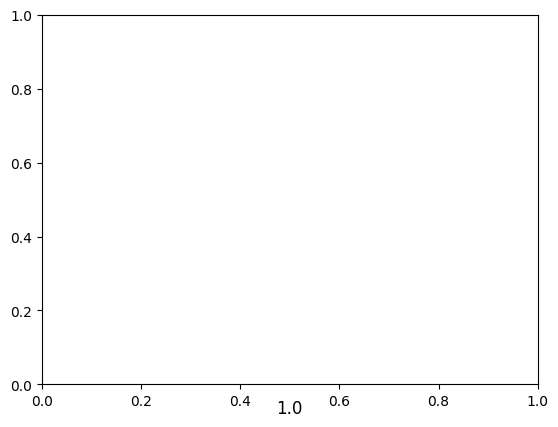

1.1


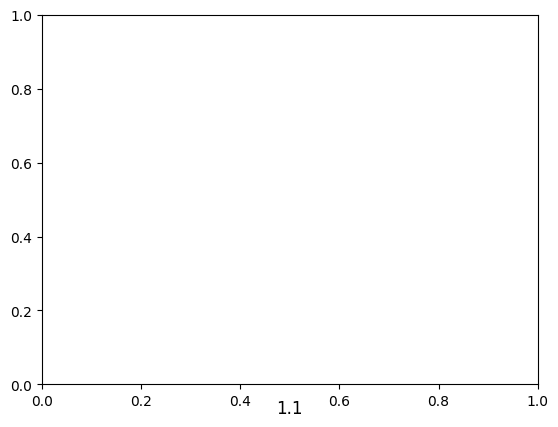

1.1


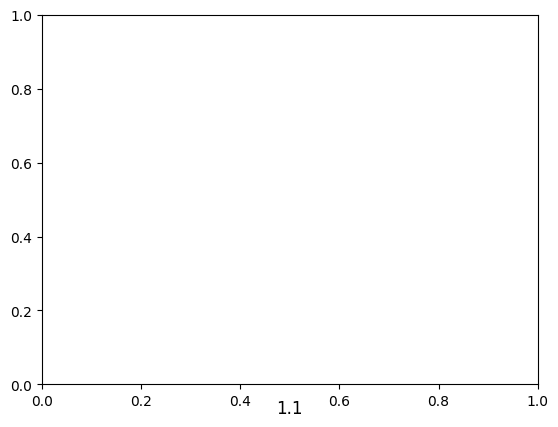

1.2


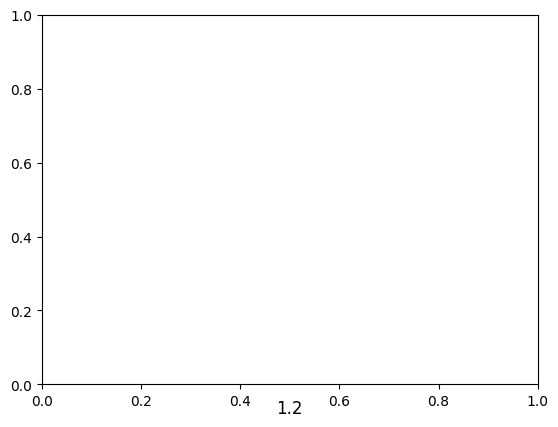

1.2


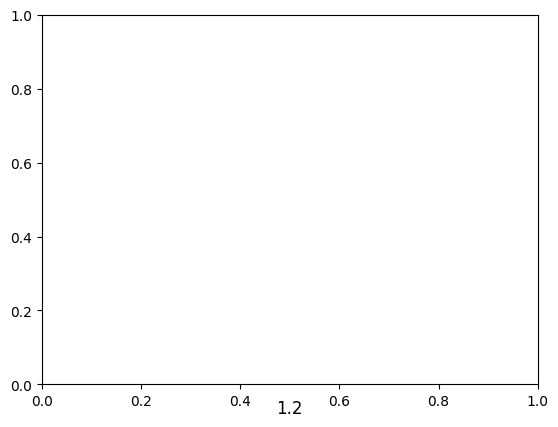

1.2


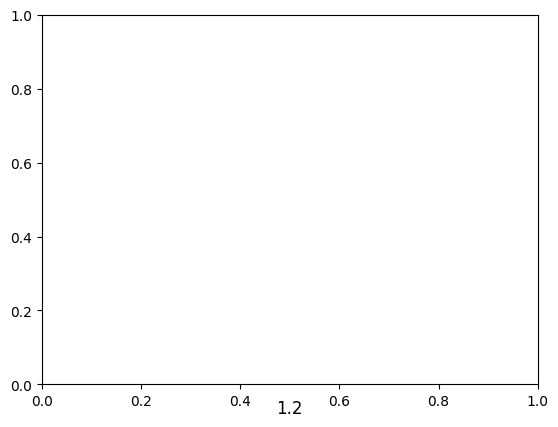

1.3


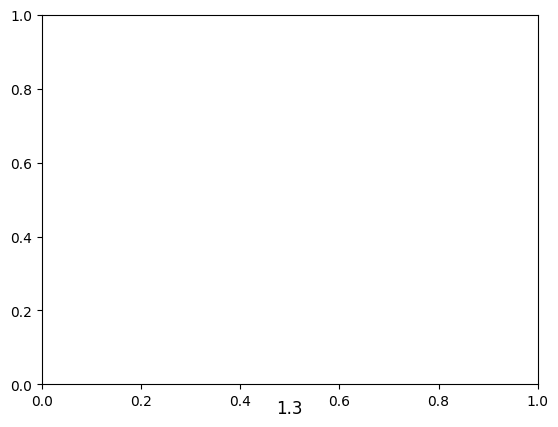

1.3


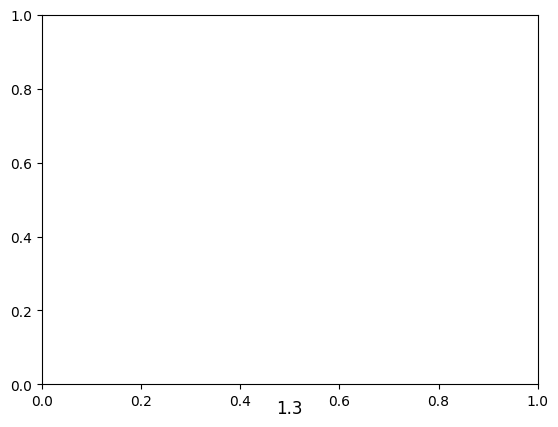

1.4


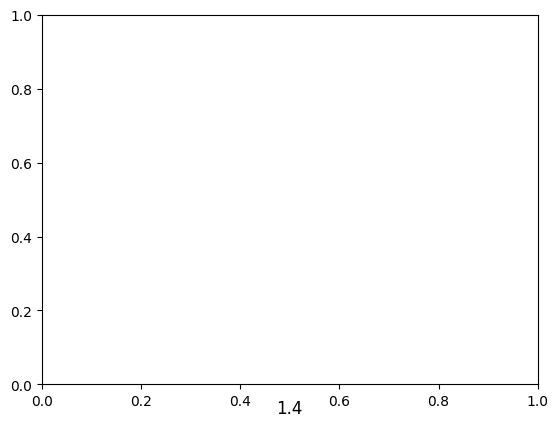

1.4


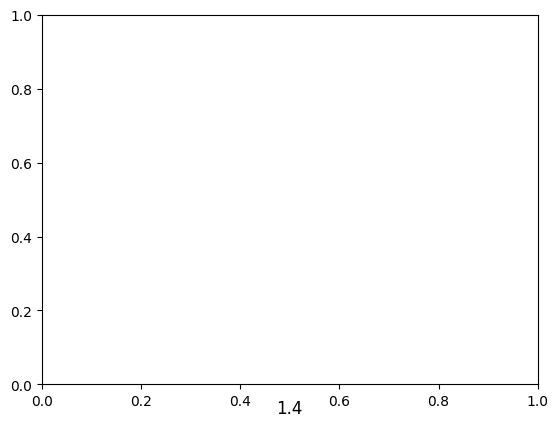

1.5


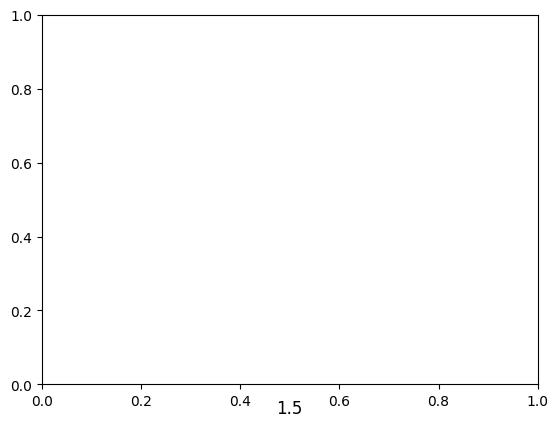

1.5


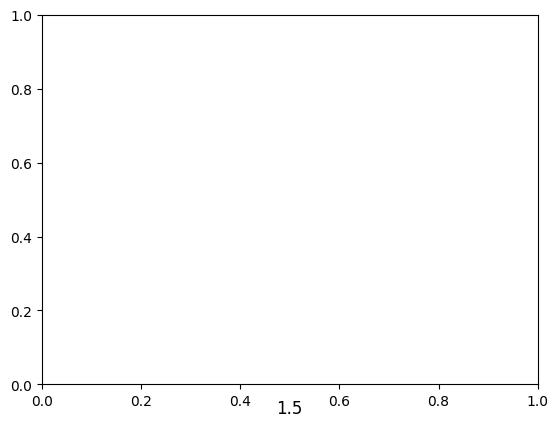

1.5


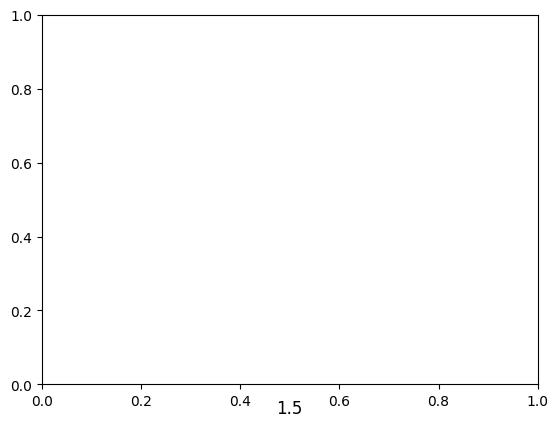

1.6


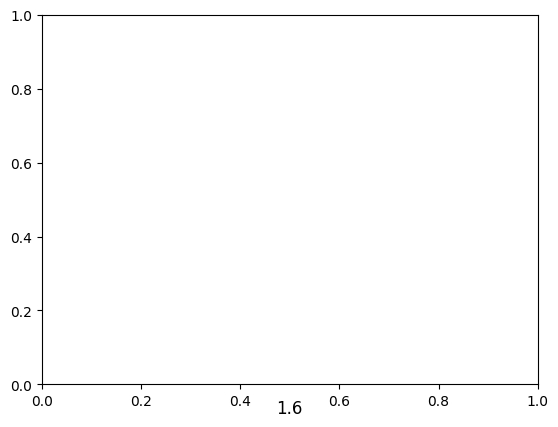

1.6


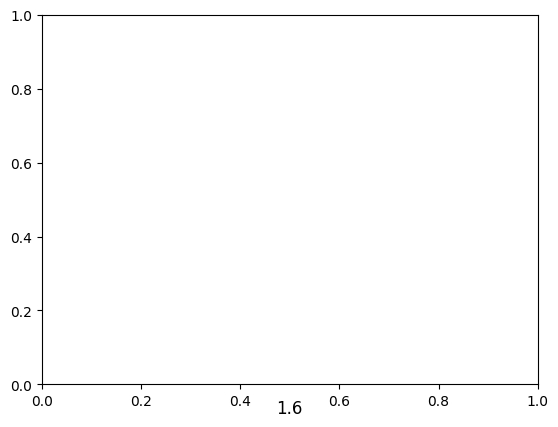

1.7


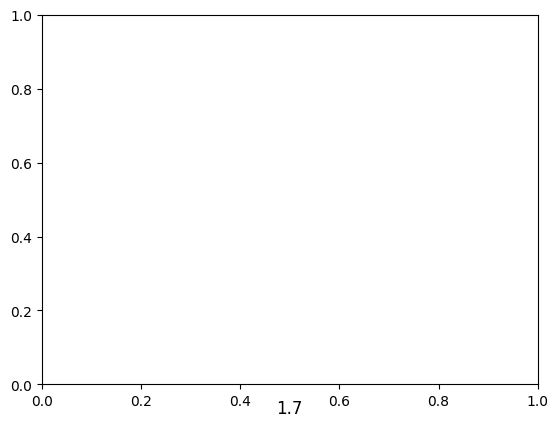

1.7


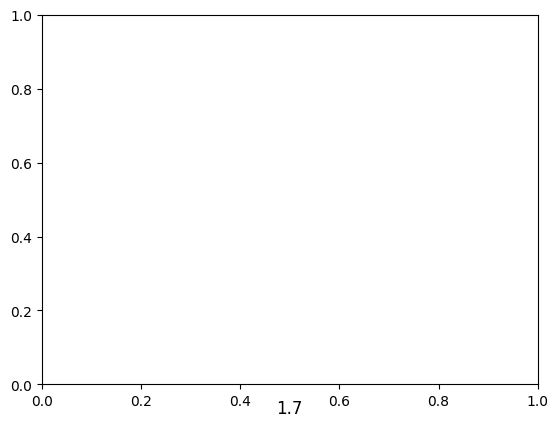

1.8


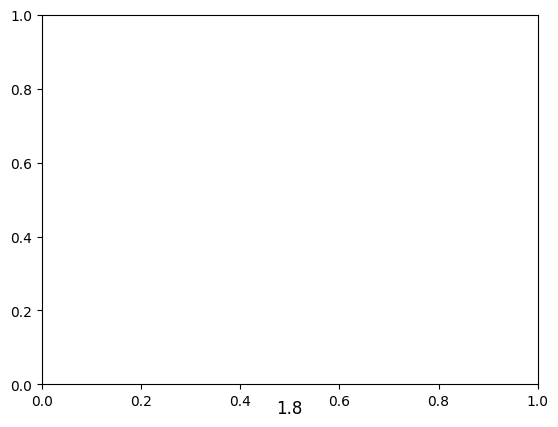

1.8


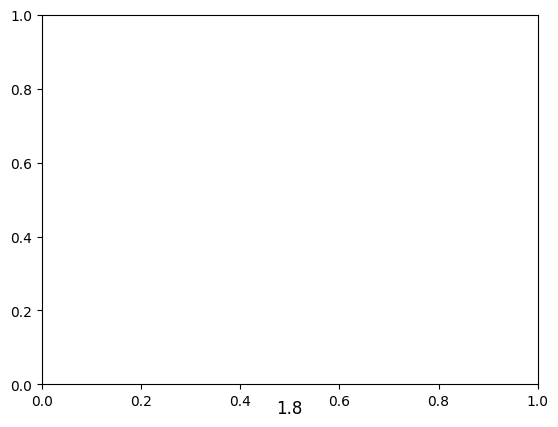

1.8


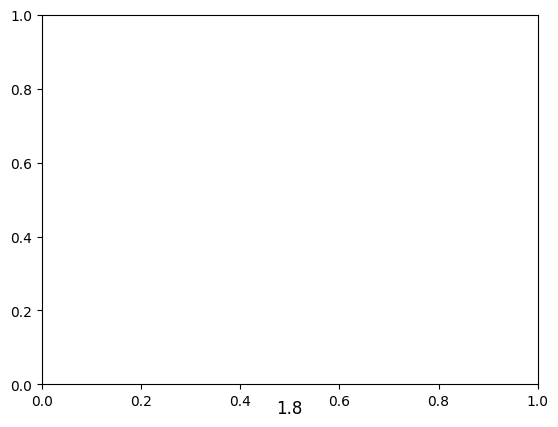

1.9


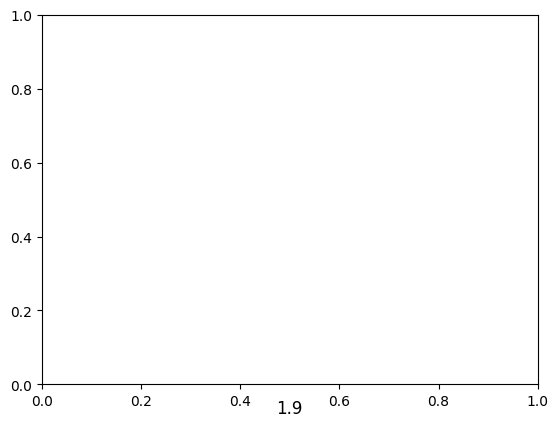

1.9


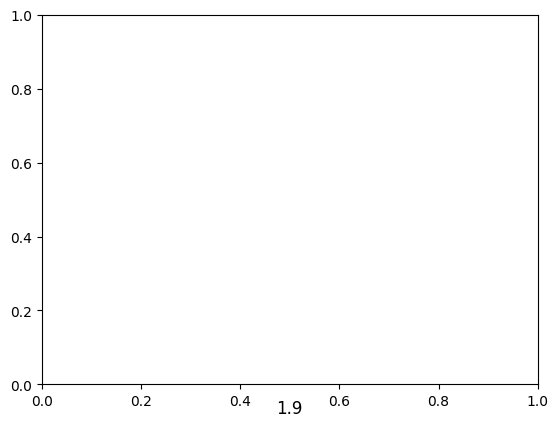

2.0


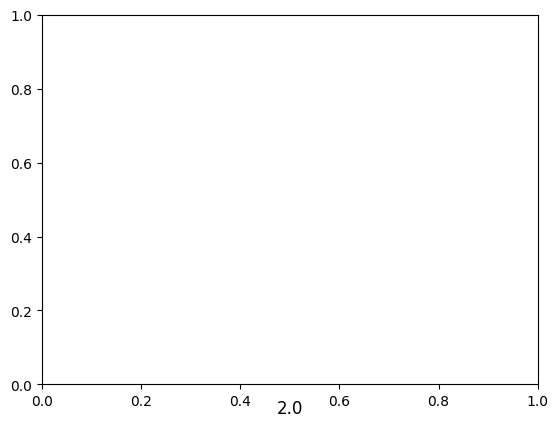

2.0


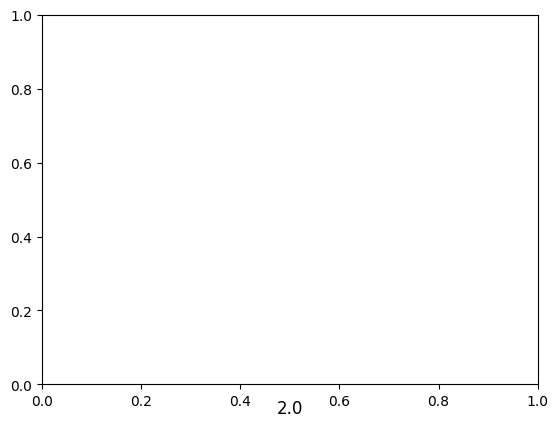

2.0


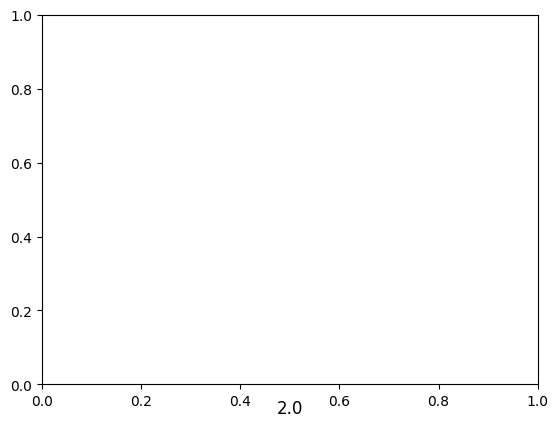

2.1


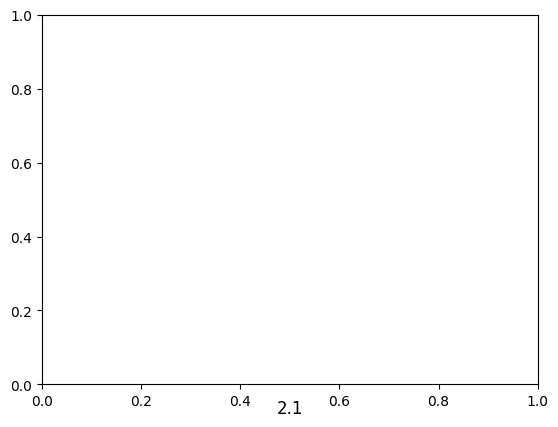

2.1


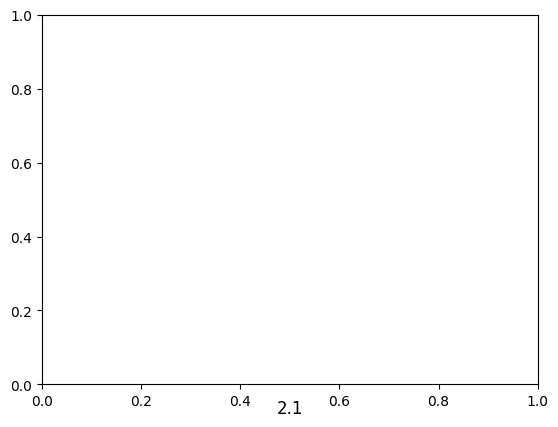

2.2


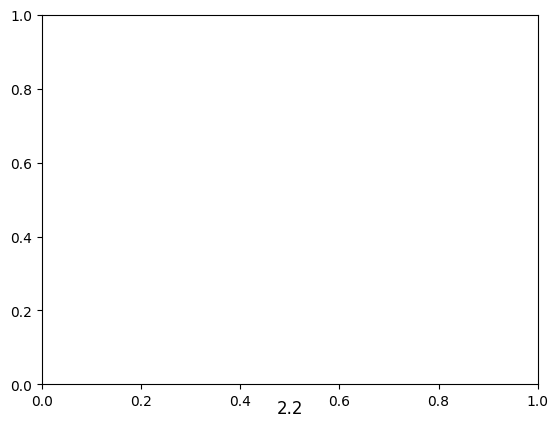

2.2


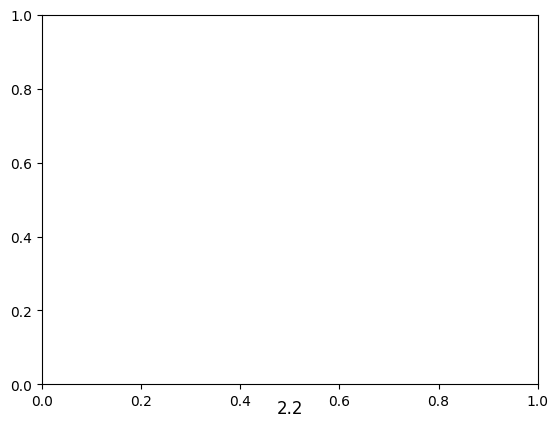

2.2


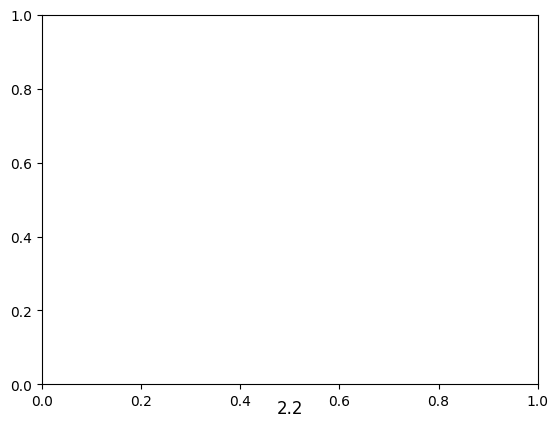

2.3


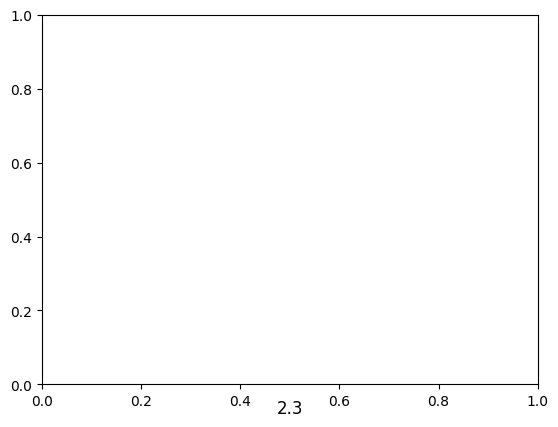

2.3


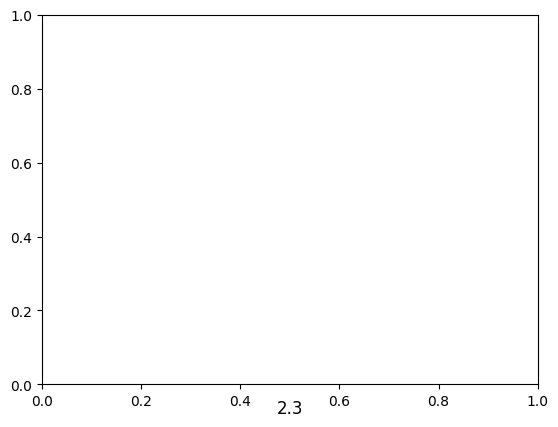

2.4


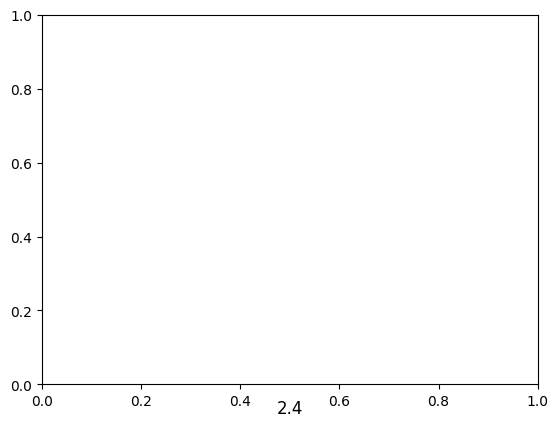

2.4


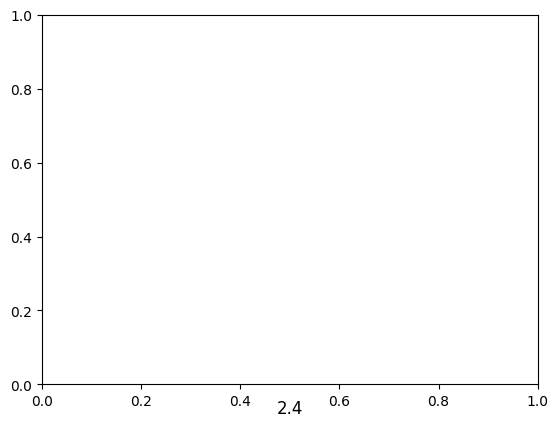

2.5


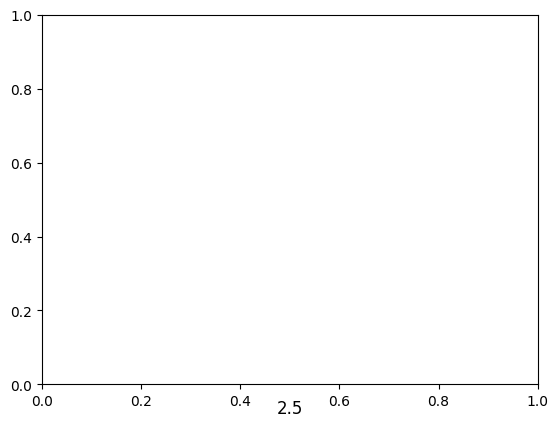

2.5


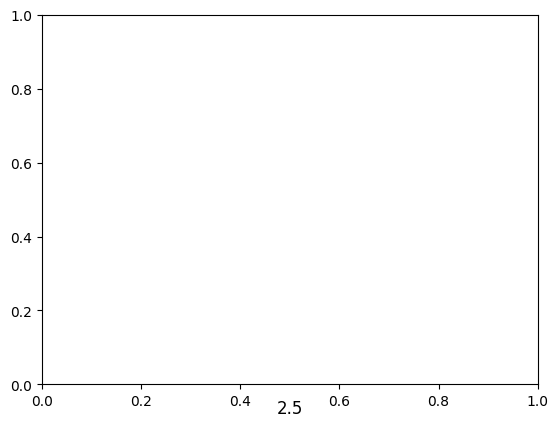

2.5


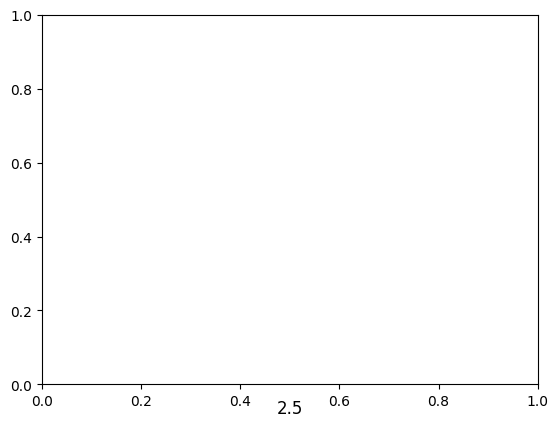

2.6


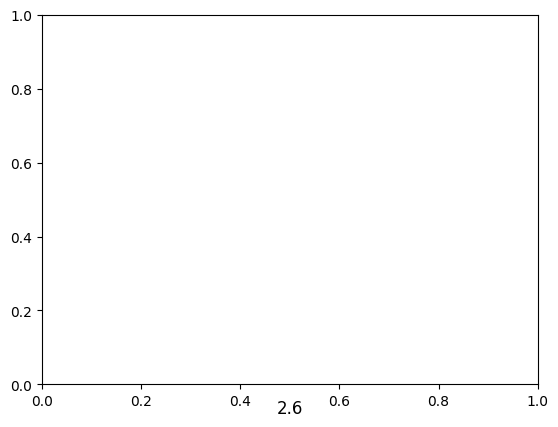

2.6


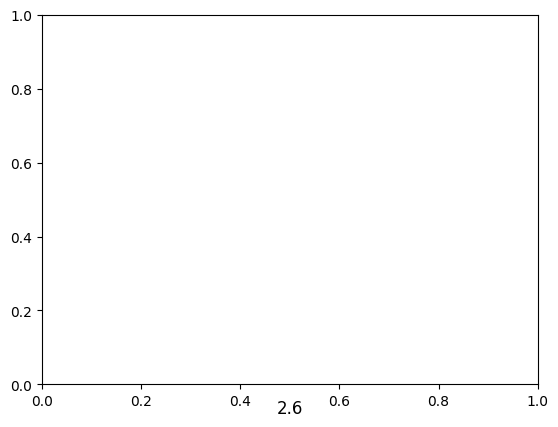

2.7


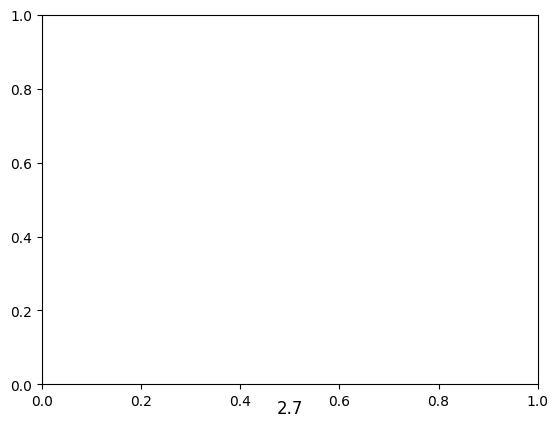

2.7


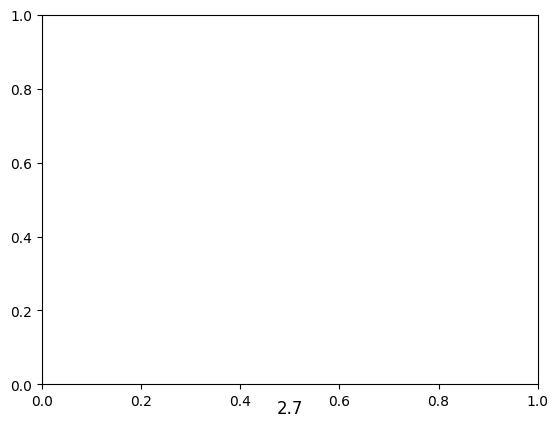

2.8


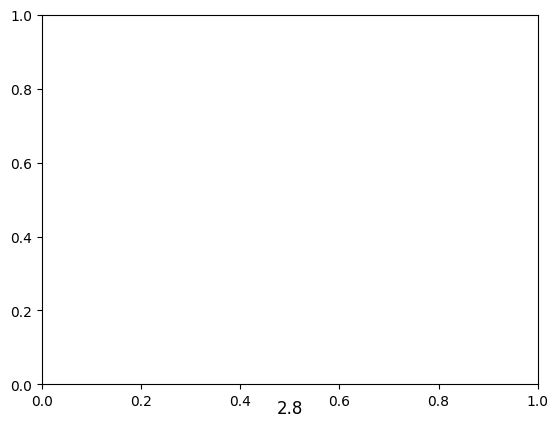

2.8


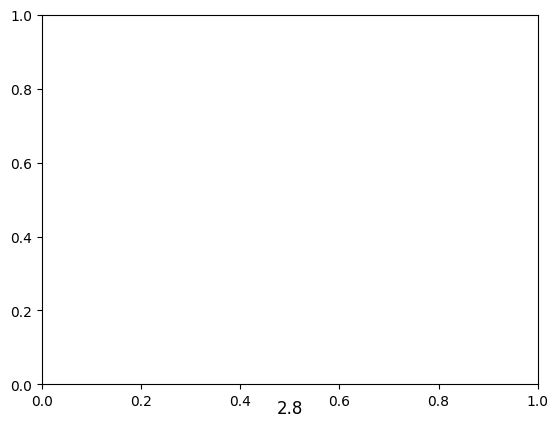

2.8


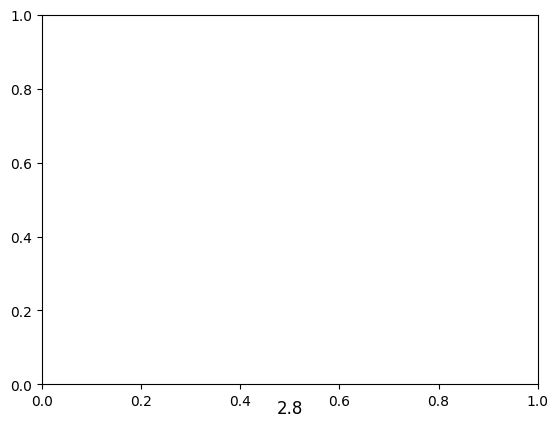

2.9


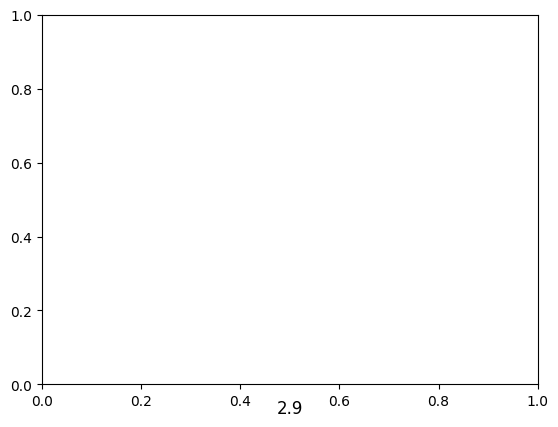

2.9


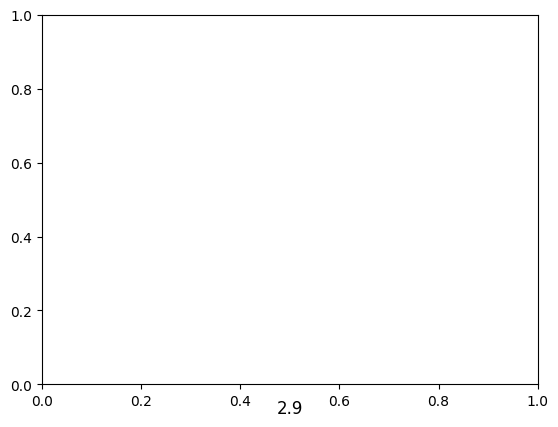

3.0


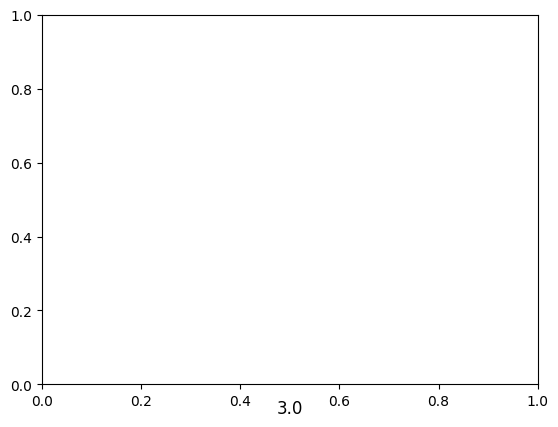

3.0


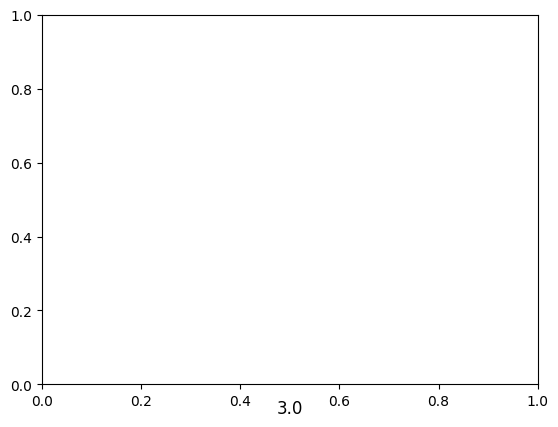

3.0


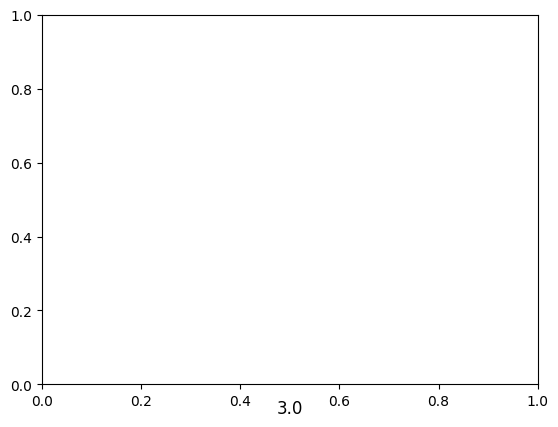

3.1


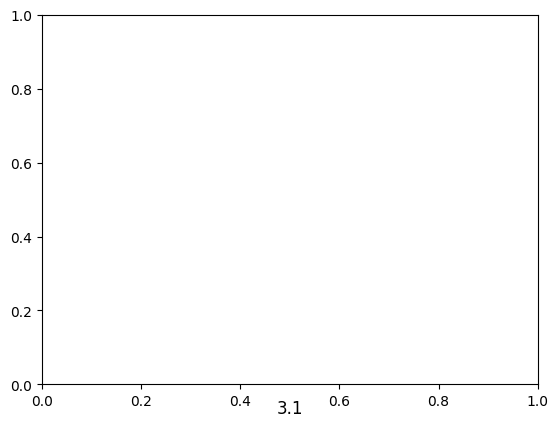

3.1


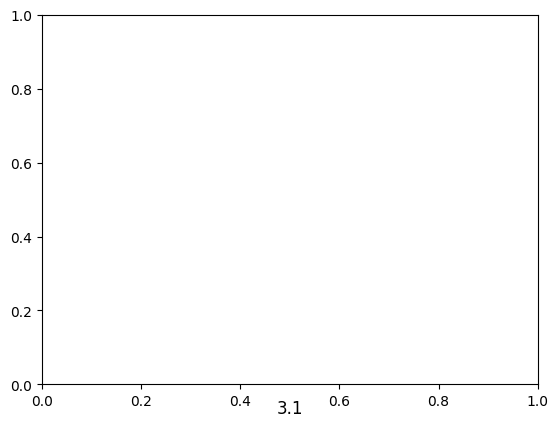

3.2


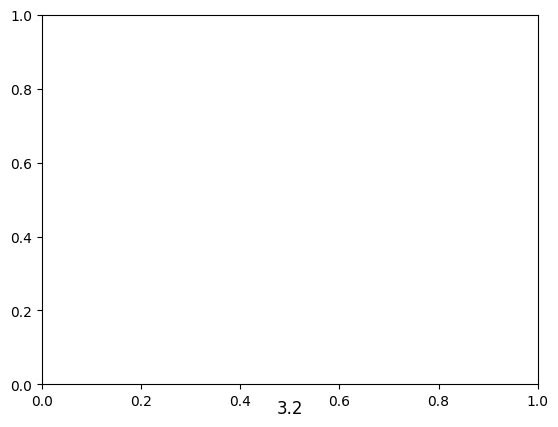

3.2


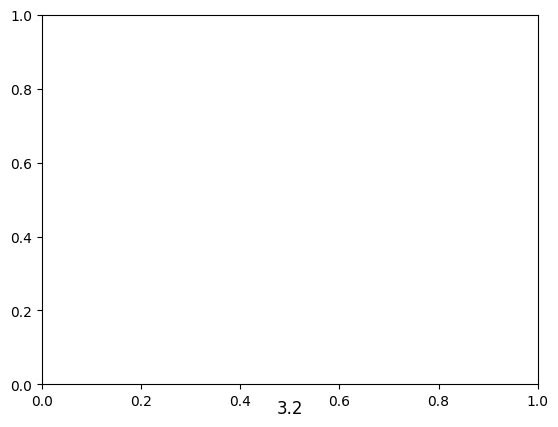

3.2


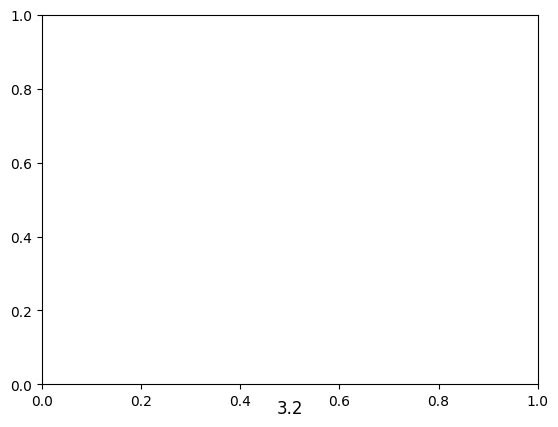

3.3


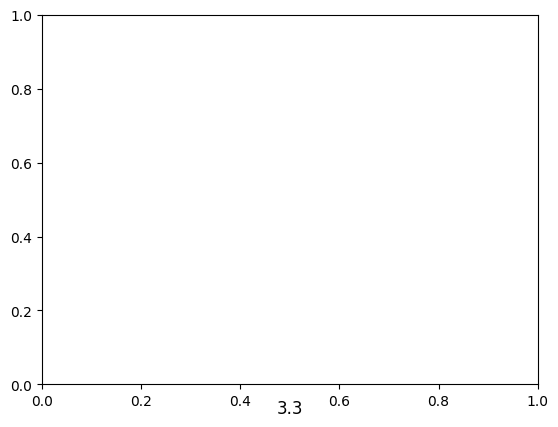

3.3


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [83]:
person_data = {}
fig = plt.figure(figsize=(10,4.5))
ax = fig.add_subplot(projection='3d')
prev_A = [[],[],[]]
prev_B = [[],[],[]]
figures_A = [[[],[]],[[],[]],[[],[]]]   
figures_B = [[[],[]],[[],[]],[[],[]]]   
plt.ion()
        

p_x=np.linspace(-10,10,15)
p_y=np.linspace(-10,10,15)
X,Y=np.meshgrid(p_x,p_y)

for stream_person in data:
    person_data[stream_person] = np.array(data[stream_person])

ax.set_xlim3d([0, 1])
ax.set_ylim3d([0, 1])
ax.set_zlim3d([1.2,2.2]) 
for timestep in range(0, len(data[list(data.keys())[0]]), 5):
    print(round(timestep/120, 1))
    joint_data_A = person_data["Kushal"]
    joint_data_B = person_data["Prithwish"]
    current_joints_A = get_relevant_joints(joint_data_A[timestep])
    history_joints_A = get_history(joint_data_A, timestep)
    future_joints_A = get_future(joint_data_A, timestep)
    forecast_joints_A = get_forecast(history_joints_A)
    current_joints_B = get_relevant_joints(joint_data_B[timestep])
    history_joints_B = get_history(joint_data_B, timestep)
    future_joints_B = get_future(joint_data_B, timestep)
    forecast_joints_B = get_forecast(history_joints_B)

    update = True
    if timestep == 0:
        update = False
    get_point_array(current_joints=current_joints_A, 
                    future_joints=None, 
                    forecast_joints=forecast_joints_A, figures=figures_A, ax=ax, update=update, prev=prev_A, threshold=100)
    get_point_array(current_joints=current_joints_B, 
                    future_joints=None, 
                    forecast_joints=forecast_joints_B, figures=figures_B, ax=ax, update=update, prev=prev_B, threshold=.8)
    plt.title(str(round(timestep/120, 1)),y=-0.1)
    plt.pause(.0001)
plt.ioff()
plt.show()
plt.close()